# **Homework 2-1 Phoneme Classification**

## The DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus (TIMIT)
The TIMIT corpus of reading speech has been designed to provide speech data for the acquisition of acoustic-phonetic knowledge and for the development and evaluation of automatic speech recognition systems.

This homework is a multiclass classification task, 
we are going to train a deep neural network classifier to predict the phonemes for each frame from the speech corpus TIMIT.

link: https://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3

## Download Data
Download data from google drive, then unzip it.

You should have `timit_11/train_11.npy`, `timit_11/train_label_11.npy`, and `timit_11/test_11.npy` after running this block.<br><br>
`timit_11/`
- `train_11.npy`: training data<br>
- `train_label_11.npy`: training label<br>
- `test_11.npy`:  testing data<br><br>

**notes: if the google drive link is dead, you can download the data directly from Kaggle and upload it to the workspace**




In [2]:
#check device
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

## Create Dataset

In [3]:
import torch
from torch.utils.data import Dataset

class TIMITDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


## Preparing Data
Load the training and testing data from the `.npy` file (NumPy array).

Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from operator import itemgetter

print('Loading data ...')

data_root='./timit_11/'

SKIP_FRAME = 4
SHUFFLE = True

train = np.load(data_root + 'train_11.npy')
train_first = train[:, :-39*SKIP_FRAME]
# train_mid = train[:, 39*4:-39*4]
train_last = train[:, 39*SKIP_FRAME:]
train = np.c_[train_first, train_last]
del train_first, train_last

print('Size of training data: {}'.format(train.shape))

train_label = np.load(data_root + 'train_label_11.npy')

VAL_RATIO = 0.1
# SELF_TEST_SET_RATIO = 0.1
'''
# TODO: 
    (1) self test set
    (2) corss-fold valid
'''

if SHUFFLE:
    train_x, val_x, train_y, val_y = train_test_split(train, train_label, test_size=VAL_RATIO, random_state=1126)
else:
    percent = int(train.shape[0] * (1 - VAL_RATIO))
    train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]

print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Loading data ...
Size of training data: (1229932, 546)
Size of training set: (983945, 546)
Size of validation set: (245987, 546)


In [5]:
import matplotlib.pyplot as plt

def plot_counter_hist(y):
    plt.figure(figsize=(10, 6))
    val_cnt = Counter(y).items()
    print(len(val_cnt))
    val_cnt = [(int(e[0]), e[1]) for e in val_cnt]
    val_cnt = sorted(val_cnt, key=itemgetter(0))
    val_cnt = Counter(dict(val_cnt))
    plt.bar(val_cnt.keys(), val_cnt.values())
    plt.show()

39


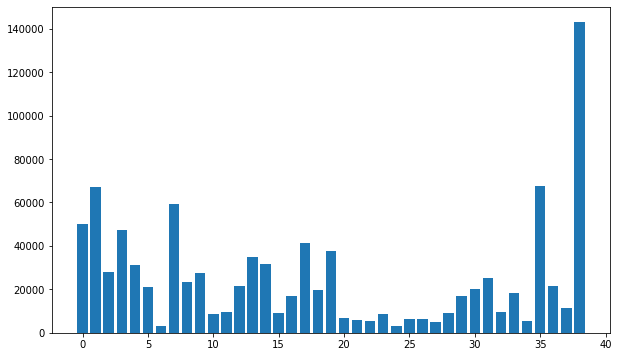

In [6]:
plot_counter_hist(train_y)

39


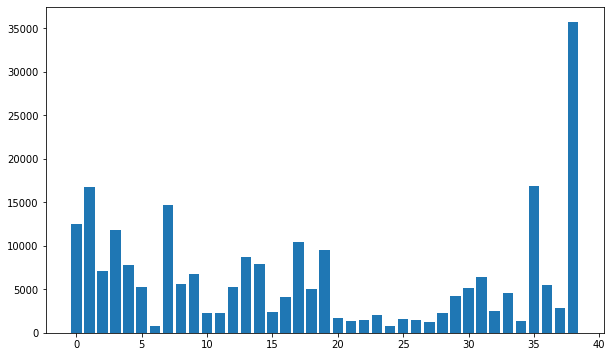

In [7]:
plot_counter_hist(val_y)

In [8]:
def get_weights(train_y, method=0):
    _cnt = Counter(train_y).items()
    _cnt = [(int(e[0]), e[1]) for e in _cnt]
    _cnt = sorted(_cnt, key=itemgetter(0))
    nSamples = [e[1] for e in _cnt]
    total = sum(nSamples)
    print(total)
    print(nSamples)
    
    device = get_device()

    if method == 0:
        weights = None
    elif method == 1:
        weights = [1 - (x / total) for x in nSamples]
        print(weights)
    elif method == 2:
        percentage = [ x / total for x in nSamples]
        print(percentage)
        weights = []
        for p in percentage:
            if p > 0.1:
                weights.append(0.75)
            elif p < 0.01:
                weights.append(1.25)
            else:
                weights.append(1)
    weights = torch.FloatTensor(weights).to(device)
    return weights

method = 1
weights = get_weights(train_y, method=method)
print(weights)

983945
[50241, 67005, 27981, 47259, 31194, 21097, 3248, 59093, 23161, 27500, 8802, 9386, 21470, 34689, 31702, 8953, 16836, 41133, 19864, 37533, 6804, 5681, 5635, 8570, 3095, 6581, 6302, 4854, 9251, 16816, 19976, 25215, 9527, 18374, 5531, 67598, 21642, 11339, 143007]
[0.9489392191636727, 0.9319016814964252, 0.9715624348921942, 0.9519698763650407, 0.968297008471002, 0.9785587609063515, 0.996699002484895, 0.9399427813546489, 0.976461082682467, 0.9720512833542525, 0.991054378039423, 0.9904608489295641, 0.9781796746769382, 0.9647449806645697, 0.9677807194507824, 0.9909009141771136, 0.9828892875109889, 0.9581958341167444, 0.9798118797290499, 0.9618545752049149, 0.9930849793433576, 0.994226303299473, 0.994273053880044, 0.9912901635762161, 0.9968544989811422, 0.9933116180274304, 0.9935951704617636, 0.9950667974327834, 0.9905980517203705, 0.9829096138503677, 0.979698052228529, 0.9743735676282719, 0.9903175482369442, 0.9813261920127649, 0.9943787508448135, 0.9312990055338459, 0.9780048681582812,

Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

In [9]:
BATCH_SIZE = 8192

from torch.utils.data import DataLoader

train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

import gc

del train, train_label, train_x, train_y, val_x, val_y
gc.collect()

test = np.load(data_root + 'test_11.npy')
test_first = test[:, :-39*SKIP_FRAME]
# test_mid = test[:, 39*4:-39*4]
test_last = test[:, 39*SKIP_FRAME:]
test = np.c_[test_first, test_last]
del test_first, test_last

print('Size of testing data: {}'.format(test.shape))

Size of testing data: (451552, 546)


## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Mish activation loaded...


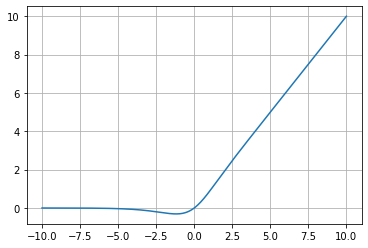

In [11]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        print("Mish activation loaded...")
    def forward(self,x):
        x = x * (torch.tanh(F.softplus(x)))
        return x

mish = Mish()
x = torch.linspace(-10,10,1000)
y = mish(x)
 
plt.plot(x,y)
plt.grid()
plt.show()

In [12]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        input_shape = 39*(11-SKIP_FRAME)*2
        Size1 = 1024
        Size2 = 1024
        Size3 = 1024
        Size4 = 1024

        prob = 0.5
        
        self.net = nn.Sequential(
            nn.Dropout(p=0.05),
            
            nn.Linear(input_shape, Size1),
            nn.ReLU(),
            nn.BatchNorm1d(Size1),
            nn.Dropout(p=prob),
            
            nn.Linear(Size1, Size2),
            nn.ReLU(),
            nn.BatchNorm1d(Size2),
            nn.Dropout(p=prob),
            
            nn.Linear(Size2, Size3),
            nn.ReLU(),
            nn.BatchNorm1d(Size3),
            nn.Dropout(p=prob),
            
            nn.Linear(Size3, Size4),
            nn.ReLU(),
            nn.BatchNorm1d(Size4),
            nn.Dropout(p=prob),
            
            nn.Linear(Size4, 39)
        )

    def forward(self, x):
        return self.net(x)

## Fix random seeds for reproducibility.

In [13]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Training Config.

In [91]:
config = {
    'seed': 1126,
    'num_class': 39,               # number of class
    'num_epoch': 2048,             # number of training epoch
    'Lookahead': False,             # Using Lookahead
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 1e-3,                 # learning rate 
        'weight_decay' : 1e-4,          # weight_decay
        # 'weight_decay' : 0,          # weight_decay for PReLU
        # 'momentum': 0.9,               # momentum for SGD
        # 'nesterov': True,            # nesterov for SGD
    },
    'EARLY_STOP' : 128,              # early stop setting ( = lr_param * 4)
    'lr_scheduler': 'ReduceLROnPlateau', # learning rate scheduler
#    'lr_scheduler': 'CosineAnnealingLR',
    'lr_scheduler_paras': {
        'patience' : 16,                # patience for ReduceLROnPlateau
        'factor': 0.5,                 # Reduction factor for ReduceLROnPlateau
#         'T_max': 64,                # T_max for CosineAnnealingLR
    },
    'loss_ratio' : 1. ,             # save the model for best accuracy, range: [0-1] 1: valid set, 0: train set
    'weights': weights,             # weights for Corss Entropy Loss
    'ensemble': True,               # Ensemble when training
    'ensemble_thres': 0.768,         # thresold for ensenble prediction (0.759 for cosine, 0.76x for Reduce)
    'post_process': True,          # Post processing when ensemble
    'final_process': True,          # Post processing after ensemble
    'LabelSmoothingLoss': False        # Label Smoothing Loss
}

Stop Criterion

In [92]:
def stop_criterion(early_stop_cnt, curr_lr, acc, thres = 0.7725):
    flag = True
    for a in acc:
        if a < thres:
            flag = False
            break
        
    if flag:
        print('acc > ', thres)
        return True
    elif early_stop_cnt > config['EARLY_STOP']:
        print('early_stop_cnt > ', config['EARLY_STOP'])
        return True
    else:
        return False

Ensemble Criterion

In [93]:
def ensemble_criterion(acc, thres = 0.76):
    if acc[0] > thres and acc[1] > thres:
        return True
    else:
        return False

In [94]:
from datetime import date
from datetime import datetime
def get_date_time():
    # datetime object containing current date and time
    # dd/mm/YY H:M:S
    now = datetime.now()
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
    print('Now:', dt_string)
    
    today = dt_string[5:10].replace('/', '')
    print("Today's date:", today)
    
    CURR_TIME = dt_string[-8:-3].replace(':', '')
    print("current time:", CURR_TIME)
    
    return today, CURR_TIME

In [95]:
device = get_device()
model = Classifier().to(device)
## Initializer
# initializer = XavierInitializer()
# model.apply(initializer)

Create a testing dataset, and load model from the saved checkpoint.

In [96]:
# create testing dataset
test_set = TIMITDataset(test, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
PREDICT = []

## Post Processing

In [97]:
def post_processing(predict):
    N = len(predict)
    case_ABA_cnt = 0
    case_ABC_cnt = 0
    continuous_cnt = {}
    temp_cnt = 1
    for i in range(1, N-1):
        if predict[i] == predict[i-1]:
            temp_cnt += 1
        else:
            if temp_cnt not in continuous_cnt:
                continuous_cnt[temp_cnt] = 1
            else:
                continuous_cnt[temp_cnt] += 1
            temp_cnt = 1
            
        if predict[i] != predict[i-1] and predict[i] != predict[i+1]:
            if predict[i-1] == predict[i+1]:
                predict[i] = predict[i-1]
                case_ABA_cnt += 1
            else:
                case_ABC_cnt += 1
                if abs(predict[i] - predict[i-1]) <= abs(predict[i] - predict[i+1]):
                    predict[i] = predict[i-1]
                else:
                    predict[i] = predict[i+1]
                 
    print('total:', N)
    print('case_ABA_cnt:', case_ABA_cnt)
    print('case_ABC_cnt:', case_ABC_cnt)
    return continuous_cnt

## Make prediction.

In [98]:
def make_prediction(model, test_loader, post_process = True):
    predict = []
    model.eval() # set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

            for y in test_pred.cpu().numpy():
                predict.append(y)
    if post_process:
        post_processing(predict)
    return predict

## Training

In [99]:
from torchtoolbox.nn import LabelSmoothingLoss
from torchtoolbox.optimizer import Lookahead
from torchtoolbox.nn.init import XavierInitializer

def Train(config, train_loader, val_loader, val_set, test_loader, model=None):
    # create model, define a loss function, and optimizer
    if not model:
        device = get_device()
        model = Classifier().to(device)
        # # Initializer
        # initializer = XavierInitializer()
        # model.apply(initializer)
        
    print(model)
    print(config)
    today, CURR_TIME = get_date_time()
    
    # get device 
    device = get_device()
    print(f'DEVICE: {device}')
    
    # Loss
    if config['LabelSmoothingLoss']:
        criterion = LabelSmoothingLoss(config['num_class'], smoothing=0.1)
    else:
        criterion = nn.CrossEntropyLoss(weight=config['weights']) 
    
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])
    if config['Lookahead']:
        optimizer = Lookahead(optimizer)
    
    scheduler = getattr(torch.optim.lr_scheduler, config['lr_scheduler'])(optimizer, **config['lr_scheduler_paras']) # learning rate scheduler
    
    # start training
    start = datetime.now()
    dt_string = start.strftime("%Y/%m/%d %H:%M:%S")
    print('Strat training at:', dt_string)

    # the path where checkpoint saved
    model_path = './models/model_{}_{}.ckpt'.format(today, CURR_TIME)

    early_stop_cnt = 0
    ensemble_cnt = 0
    best_acc = 0.0
    
    lr = config['optim_hparas']['lr']
    for epoch in range(config['num_epoch']):
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0

        # training
        model.train() # set the model to training mode
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() 
            outputs = model(inputs) 
            batch_loss = criterion(outputs, labels)
            _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
            batch_loss.backward() 
            optimizer.step() 

            train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
            train_loss += batch_loss.item()
        
        train_acc /= len(train_set)
        train_loss /= len(train_loader)
        
        # validation
        if len(val_set) > 0:
            model.eval() # set the model to evaluation mode
            with torch.no_grad():
                for i, data in enumerate(val_loader):
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    batch_loss = criterion(outputs, labels) 
                    _, val_pred = torch.max(outputs, 1) 

                    val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                    val_loss += batch_loss.item()

                scheduler.step(val_loss)
                # scheduler.step()
                
                val_acc /= len(val_set)
                val_loss /= len(val_loader)
                
                if epoch % 5 == 0:
                    print('[{:04d}/{:04d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                        epoch, 
                        config['num_epoch'], 
                        train_acc, 
                        train_loss, 
                        val_acc, 
                        val_loss
                    ))
                    
                curr_lr = optimizer.param_groups[0]['lr']
                if curr_lr != lr:
                    print('    Current learning rate: {:.8f} | early stop cnt: {}'.format(curr_lr, early_stop_cnt))
                    lr = curr_lr
                
                total_acc = val_acc * config['loss_ratio'] + train_acc * (1 - config['loss_ratio'])
                acc_check_list = [val_acc, train_acc]
                
                # if the model improves, save a checkpoint at this epoch
                if total_acc > best_acc:
                    best_acc = total_acc
                    early_stop_cnt = 0
                    torch.save(model.state_dict(), model_path)
                    print('    Saving model with Train Acc: {:.6f} | val acc: {:.6f} | total acc: {:.6f}'.format(
                        train_acc, 
                        val_acc, 
                        total_acc
                    ))
                    print()
                    if config['ensemble'] and ensemble_criterion(acc=acc_check_list, thres=config['ensemble_thres']):
                        ensemble_cnt += 1
                        print('    Ensemble_cnt: {} | Train Acc: {:.6f} | Val Acc: {:.6f}'.format(ensemble_cnt, train_acc, val_acc))
                        predict = make_prediction(model, test_loader, post_process=config['post_process'])
                        PREDICT.append(predict)
                else:
                    early_stop_cnt += 1
                
                if stop_criterion(early_stop_cnt=early_stop_cnt, curr_lr=curr_lr, acc=(train_acc, val_acc)):
                    # Stop training when satisfying stop criterion
                    print('Early stop at {} epoch'.format(epoch+1))
                    break

        else:
            print('[{:04d}/{:04d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
                epoch, config['num_epoch'], train_acc, train_loss
            ))

    # if not validating, save the last epoch
    if len(val_set) == 0:
        torch.save(model.state_dict(), model_path)
        print('saving model at last epoch')
    print('learning rate is', optimizer.param_groups[0]['lr'])
    print('Ensemble_cnt: {}'.format(ensemble_cnt))
    end = datetime.now()
    cost_time = end - start
    print('Cost Time:', str(cost_time))
    return today, CURR_TIME, best_acc

In [100]:
# fix random seed for reproducibility
same_seeds(config['seed'])
today, CURR_TIME, best_acc = Train(config, train_loader, val_loader, val_set, test_loader, model)

Classifier(
  (net): Sequential(
    (0): Dropout(p=0.05, inplace=False)
    (1): Linear(in_features=546, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=1024, out_features=1024, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=1024, out_features=1024, bias=True)
    (14): ReLU()
    (15): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_features=1024, out_features=39, bias=True)
  )
)
{'seed': 112

[0125/2048] Train Acc: 0.708086 Loss: 0.896736 | Val Acc: 0.762874 loss: 0.705362
    Saving model with Train Acc: 0.707646 | val acc: 0.763626 | total acc: 0.763626

[0130/2048] Train Acc: 0.708701 Loss: 0.894827 | Val Acc: 0.763496 loss: 0.703520
[0135/2048] Train Acc: 0.708752 Loss: 0.894674 | Val Acc: 0.761975 loss: 0.705003
    Saving model with Train Acc: 0.708974 | val acc: 0.764203 | total acc: 0.764203

[0140/2048] Train Acc: 0.708203 Loss: 0.894329 | Val Acc: 0.762922 loss: 0.705251
[0145/2048] Train Acc: 0.708834 Loss: 0.893011 | Val Acc: 0.763370 loss: 0.704456
[0150/2048] Train Acc: 0.709048 Loss: 0.893618 | Val Acc: 0.763772 loss: 0.701142
    Saving model with Train Acc: 0.708695 | val acc: 0.764349 | total acc: 0.764349

[0155/2048] Train Acc: 0.709915 Loss: 0.891824 | Val Acc: 0.762101 loss: 0.705507
    Saving model with Train Acc: 0.708984 | val acc: 0.765158 | total acc: 0.765158

[0160/2048] Train Acc: 0.708727 Loss: 0.893923 | Val Acc: 0.762805 loss: 0.704021
[016

    Saving model with Train Acc: 0.742356 | val acc: 0.793904 | total acc: 0.793904

[0370/2048] Train Acc: 0.742451 Loss: 0.772805 | Val Acc: 0.793221 loss: 0.598793
    Saving model with Train Acc: 0.742430 | val acc: 0.794416 | total acc: 0.794416

[0375/2048] Train Acc: 0.742227 Loss: 0.773468 | Val Acc: 0.794327 loss: 0.597466
[0380/2048] Train Acc: 0.743172 Loss: 0.772369 | Val Acc: 0.793477 loss: 0.598784
[0385/2048] Train Acc: 0.742946 Loss: 0.772203 | Val Acc: 0.794253 loss: 0.597562
[0390/2048] Train Acc: 0.743037 Loss: 0.770763 | Val Acc: 0.793339 loss: 0.598505
    Saving model with Train Acc: 0.742800 | val acc: 0.794794 | total acc: 0.794794

[0395/2048] Train Acc: 0.742557 Loss: 0.771548 | Val Acc: 0.794477 loss: 0.596683
[0400/2048] Train Acc: 0.743121 Loss: 0.771046 | Val Acc: 0.794859 loss: 0.596329
    Saving model with Train Acc: 0.743121 | val acc: 0.794859 | total acc: 0.794859

[0405/2048] Train Acc: 0.743598 Loss: 0.769743 | Val Acc: 0.793794 loss: 0.597549
    

    Saving model with Train Acc: 0.758556 | val acc: 0.807563 | total acc: 0.807563

    Saving model with Train Acc: 0.758582 | val acc: 0.807762 | total acc: 0.807762

[0640/2048] Train Acc: 0.758879 Loss: 0.715784 | Val Acc: 0.808278 loss: 0.553091
    Saving model with Train Acc: 0.758879 | val acc: 0.808278 | total acc: 0.808278

    Saving model with Train Acc: 0.759246 | val acc: 0.809189 | total acc: 0.809189

[0645/2048] Train Acc: 0.758959 Loss: 0.715440 | Val Acc: 0.808083 loss: 0.552572
[0650/2048] Train Acc: 0.759583 Loss: 0.713140 | Val Acc: 0.808864 loss: 0.550608
[0655/2048] Train Acc: 0.759495 Loss: 0.712537 | Val Acc: 0.808957 loss: 0.549993
    Saving model with Train Acc: 0.759568 | val acc: 0.809246 | total acc: 0.809246

    Saving model with Train Acc: 0.760052 | val acc: 0.809400 | total acc: 0.809400

    Saving model with Train Acc: 0.759827 | val acc: 0.809787 | total acc: 0.809787

[0660/2048] Train Acc: 0.759697 Loss: 0.712634 | Val Acc: 0.809466 loss: 0.54

[0910/2048] Train Acc: 0.765927 Loss: 0.690191 | Val Acc: 0.815027 loss: 0.530053
[0915/2048] Train Acc: 0.766076 Loss: 0.689307 | Val Acc: 0.814738 loss: 0.530430
[0920/2048] Train Acc: 0.766018 Loss: 0.690105 | Val Acc: 0.814905 loss: 0.530303
[0925/2048] Train Acc: 0.766424 Loss: 0.690086 | Val Acc: 0.814771 loss: 0.530520
    Current learning rate: 0.00001563 | early stop cnt: 46
[0930/2048] Train Acc: 0.766977 Loss: 0.687754 | Val Acc: 0.815303 loss: 0.529542
    Saving model with Train Acc: 0.766977 | val acc: 0.815303 | total acc: 0.815303

    Saving model with Train Acc: 0.767431 | val acc: 0.815393 | total acc: 0.815393

    Saving model with Train Acc: 0.767190 | val acc: 0.815409 | total acc: 0.815409

[0935/2048] Train Acc: 0.767340 Loss: 0.687274 | Val Acc: 0.815759 loss: 0.528169
    Saving model with Train Acc: 0.767340 | val acc: 0.815759 | total acc: 0.815759

[0940/2048] Train Acc: 0.767431 Loss: 0.685269 | Val Acc: 0.815624 loss: 0.528068
    Saving model with Train

total: 451552
case_ABA_cnt: 2206
case_ABC_cnt: 8389
    Saving model with Train Acc: 0.769041 | val acc: 0.817657 | total acc: 0.817657

    Ensemble_cnt: 22 | Train Acc: 0.769041 | Val Acc: 0.817657
total: 451552
case_ABA_cnt: 2197
case_ABC_cnt: 8403
    Saving model with Train Acc: 0.769948 | val acc: 0.817775 | total acc: 0.817775

    Ensemble_cnt: 23 | Train Acc: 0.769948 | Val Acc: 0.817775
total: 451552
case_ABA_cnt: 2170
case_ABC_cnt: 8416
[1100/2048] Train Acc: 0.769927 Loss: 0.678192 | Val Acc: 0.817559 loss: 0.522226
    Current learning rate: 0.00000391 | early stop cnt: 5
    Saving model with Train Acc: 0.769754 | val acc: 0.817901 | total acc: 0.817901

    Ensemble_cnt: 24 | Train Acc: 0.769754 | Val Acc: 0.817901
total: 451552
case_ABA_cnt: 2231
case_ABC_cnt: 8364
[1105/2048] Train Acc: 0.770075 Loss: 0.678335 | Val Acc: 0.817933 loss: 0.521972
    Saving model with Train Acc: 0.770075 | val acc: 0.817933 | total acc: 0.817933

    Ensemble_cnt: 25 | Train Acc: 0.77007

In [ ]:
# fix random seed for reproducibility

config['num_epoch'] = 256
config['optim_hparas']['lr'] = 1e-5 
today, CURR_TIME, best_acc = Train(config, train_loader, val_loader, val_set, test_loader, model)


In [101]:
print(len(PREDICT))

37


## Testing

In [102]:
# # Reset PREDICT
# PREDICT = []

if len(PREDICT) % 2 == 0:
    model_path = './models/model_{}_{}.ckpt'.format(today, CURR_TIME)
    # model_path = './models/model_0322_1535.ckpt'

    # create model and load weights from checkpoint
    model = Classifier().to(device)
    model.load_state_dict(torch.load(model_path))
    predict = make_prediction(model, test_loader, post_process = True)
    PREDICT.append(predict)

In [116]:
#last_PREDICT = PREDICT[-9:]

## Find the mode (voting for ensemble results)

In [117]:
from scipy import stats
#print(len(last_PREDICT))
#print(len(last_PREDICT[0]))
#mode = stats.mode(last_PREDICT, axis=0)
print(len(PREDICT))
print(len(PREDICT[0]))
mode = stats.mode(PREDICT, axis=0)
print(mode[0].shape)

9
451552
(1, 451552)


In [118]:
N = (mode[0].shape)[1]
print(N)
result = []
for i in range(N):
    result.append(mode[0][0][i])

451552


In [119]:
if config['final_process']:
    post_processing(result)

total: 451552
case_ABA_cnt: 2
case_ABC_cnt: 14


In [120]:
name_best_acc = str(best_acc).replace('.', '')[:7]
# name_best_acc = '_EnsembleLast3'

## Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [121]:
# today = '0326'
# CURR_TIME = '1723'
def write_csv(predict, today, CURR_TIME, name_best_acc, SHUFFLE):
    if SHUFFLE:
        file_path = 'prediction_{}___{}_3_shuffle_correction_{}.csv'.format(today, CURR_TIME, name_best_acc)
    else:
        file_path = 'prediction_{}___{}_3_correction_{}.csv'.format(today, CURR_TIME, name_best_acc)
    
    with open(file_path, 'w') as f:
        f.write('Id,Class\n')
        for i, y in enumerate(predict):
            f.write('{},{}\n'.format(i, y))

In [122]:
write_csv(result, today, CURR_TIME, name_best_acc, SHUFFLE)

In [ ]:
'''
# TODO:
V _ 3. ensemble when training / ensemble previous model prediction or csv
 V  4. rewrite model into nn.Sequential
 V  5. label smoothing
    6. CNN (dilated?)
 V  7. activation function? -> Relu
 V  8. optimizer (SGD v.s. Adam) -> Adam fast
V_V 9. LR scheduler / warm up / look-ahead
    10. layer order?
        Rule: 
        * dropout-BN -> Affect
        * Act-BN -> Affect 
        
      V (1) FC-BN-dropout-Act (My best)
        (2) FC-BN-Act-dropout (Same as (1) ?)
        ---
        (3) FC-Act-dropout-BN (stack overflow)
        (4) FC-dropout-Act-BN (Same as (3) ? but computation cost less than (3)? )
        ---
      V (5) FC-Act-BN-dropout (Paka)  -> Act before BN would affect
     ?? (6) FC-dropout-BN-Act         -> dropout would affect BN
        ---
      V (7) BN-dropout-FC-Act (paper) -> similar to Paka
    11. tsne 
    12. Plot learning curve
    13. Confusion Matrix
'''

## Reference
1. Weights in Cross Entropy Loss
    - https://discuss.pytorch.org/t/weights-in-weighted-loss-nn-crossentropyloss/69514
2. Pytorch-toolbox
    - https://github.com/PistonY/torch-toolbox#1-labelsmoothingloss

## Finetune

In [ ]:
def finetune(lr = 1e-3, num_epoch = 128, valid_ratio = 0):
    train = np.load(data_root + 'train_11.npy')
    train_first = train[:, :-39*SKIP_FRAME]
    # train_mid = train[:, 39*4:-39*4]
    train_last = train[:, 39*SKIP_FRAME:]
    train = np.c_[train_first, train_last]
    del train_first, train_last

    print('Size of training data: {}'.format(train.shape))

    train_label = np.load(data_root + 'train_label_11.npy')

    VAL_RATIO = valid_ratio

    percent = int(train.shape[0] * (1 - VAL_RATIO))
    # train_x, val_x, train_y, val_y = train_test_split(train, train_label, test_size=VAL_RATIO, random_state=139)
    train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
    print('Size of training set: {}'.format(train_x.shape))
    print('Size of validation set: {}'.format(val_x.shape))

    BATCH_SIZE = 8192

    train_set = TIMITDataset(train_x, train_y)
    val_set = TIMITDataset(val_x, val_y)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

    del train, train_label, train_x, train_y, val_x, val_y
    gc.collect()

    config['optim_hparas']['lr'] = lr
    config['num_epoch'] = num_epoch

    today, CURR_TIME, best_acc = Train(config, train_loader, val_loader, val_set, model)
    return today, CURR_TIME, best_acc

In [ ]:
# today, CURR_TIME, best_acc = finetune(lr = 1e-2, num_epoch = 1024, valid_ratio = 0.2)